In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish_validation_train


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

sys.path.append("../../")

from src.ad_hmm import sku_predict
# from src.ad_stl_model import stl_model
from src.utils import *
import pickle

In [3]:
%load_ext autoreload 
%autoreload 

In [4]:
VERSION = "final1"

### Get all HMM SKU's

In [5]:
with open('../../results/final_sku_model_map.pkl', 'rb') as handle:
    sku_period_dict1 = pickle.load(handle)

In [6]:
sku_period_dict1.keys()

dict_keys(['rmse_du_15', 'rmse_du_30', 'rmse_du_45', 'rmse_du_60', 'rmse_du_90', 'rmse_du_MSTL', 'rmse_du_STL', 'rmse_du_holt', 'rmse_du_max', 'rmse_du_null', 'rmse_du_prophet'])

In [7]:
hmm_keys = ['rmse_du_15', 'rmse_du_30', 'rmse_du_45', 'rmse_du_60', 'rmse_du_90', 'rmse_du_max']

In [8]:
import itertools
hmm_skus = [sku_period_dict1[sub_model] for sub_model in hmm_keys]
hmm_skus = list(itertools.chain.from_iterable(hmm_skus))

In [9]:
len(hmm_skus),len(set(hmm_skus))

(228, 193)

Difference above due to common SKUs

In [10]:
hmm_skus = list(set(hmm_skus))

### Already done

In [11]:
import os
all_results = os.listdir('../../results/hmm_results/')
len(all_results)

175

In [12]:
df_list = []
for file in all_results:
    df_file = pd.read_csv(f'../../results/hmm_results/{file}')
    df_list.append(df_file)

In [13]:
hmm_results = pd.concat(df_list)
hmm_results.shape

(1820, 8)

In [14]:
completed_skus = hmm_results["Encoded_SKU_ID"].unique()

In [15]:
remaining_skus = set(hmm_skus) - set(completed_skus)
len(remaining_skus)

87

### Prepare Train data

In [16]:
original_train = pd.read_csv("../../data/train_validation_marker.csv")
original_train["SALES_DATE"] = pd.to_datetime(original_train["SALES_DATE"])

In [17]:
original_train["SALES_DATE"].max()

Timestamp('2022-07-31 00:00:00')

In [19]:
sku_in_scope = original_train[(original_train.Encoded_SKU_ID.isin(remaining_skus)) &(original_train.SALES_DATE>="2022-03-15"\
                         )].groupby("Encoded_SKU_ID")["DAILY_UNITS"].nunique()

In [20]:
sku_in_scope.count()

87

In [21]:
(sku_in_scope<=10).sum()

87

<AxesSubplot: >

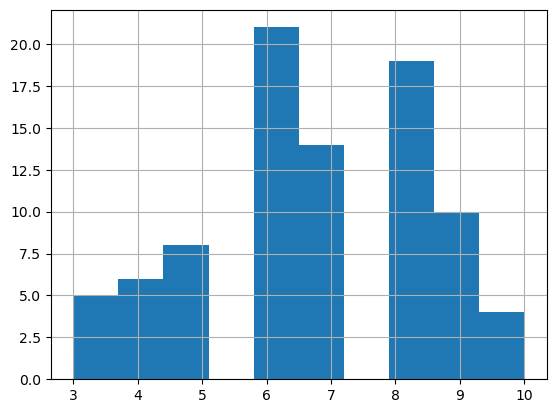

In [22]:
sku_in_scope.hist()

### Prepare dummy data for  forecasting

In [23]:
dummy_forecast = pd.DataFrame()
dummy_forecast.index = pd.date_range(start='08/01/2022', end='08/07/2022')
dummy_forecast

""
2022-08-01
2022-08-02
2022-08-03
2022-08-04
2022-08-05
2022-08-06
2022-08-07


### Test for one SKU

In [24]:
sku_id = sku_in_scope.index[0]
n_comps = max(sku_in_scope[sku_id],10) #Limit to max 10 components
sku_pred_model = sku_predict(original_train, sku_id)
feats_sku = sku_pred_model.get_features(n_lags=2)
train1, _ = sku_pred_model.split_train_test("2022-07-31")
valid1 = dummy_forecast
sku_pred_model.fit_hmm(train1, "2022-03-01", n_components1=n_comps)

Created 2 lag features
Training on : ['DAILY_UNITS_lag1', 'DAILY_UNITS_lag2'] ['change_lag1', 'change_lag2']


/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish_validation_train/../../src/ad_hmm.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data[du_lag] = sales_data["DAILY_UNITS"].shift(lag)
/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish_validation_train/../../src/ad_hmm.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data[f"change_lag{lag}"] = (sales_data["DAILY_UNITS"] - sales_data[du_lag])
/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish_validatio

In [25]:
sku_pred_model.predict(valid1, 15)

Starting Prediction
-----> Predicting for day:0


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 179 free scalar parameters with only 60 data points will result in a degenerate solution.
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/hmmlearn/hmm.py:206: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(X

-----> Predicting for day:1


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 179 free scalar parameters with only 60 data points will result in a degenerate solution.
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/hmmlearn/hmm.py:206: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(X

-----> Predicting for day:2


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 179 free scalar parameters with only 60 data points will result in a degenerate solution.
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/hmmlearn/hmm.py:206: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(X

-----> Predicting for day:3


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 179 free scalar parameters with only 60 data points will result in a degenerate solution.
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/hmmlearn/hmm.py:206: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(X

-----> Predicting for day:4


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 179 free scalar parameters with only 60 data points will result in a degenerate solution.
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/hmmlearn/hmm.py:206: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(X

-----> Predicting for day:5


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 179 free scalar parameters with only 60 data points will result in a degenerate solution.
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashish1610dhiman/opt/anaconda3/envs/bestbuy/lib/python3.9/site-packages/hmmlearn/hmm.py:206: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  kmeans.fit(X

-----> Predicting for day:6


,DAILY_UNITS_lag1,DAILY_UNITS_lag2,change_lag1,change_lag2,predicted1,predicted2,predicted
2022-08-01,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
2022-08-02,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2022-08-03,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
2022-08-04,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2022-08-05,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
2022-08-06,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2022-08-07,1.0,0.0,-1.0,0.0,0.0,0.0,0.0


### Parallel function

In [26]:
pd.options.mode.chained_assignment = None
from tqdm import tqdm

from IPython.utils import io
from joblib import Parallel, delayed

In [27]:
error_prediction = pd.DataFrame()
error_prediction.index = pd.date_range(start='08/01/2022', end='08/07/2022')
error_prediction["predicted"] = np.nan
error_prediction

,predicted
2022-08-01,NaN
2022-08-02,NaN
2022-08-03,NaN
2022-08-04,NaN
2022-08-05,NaN
2022-08-06,NaN
2022-08-07,NaN


In [30]:
def parallel_hmm_function(sku_id):
    n_comps = max(sku_in_scope[sku_id],10) #Limit to max 10 components
    sku_pred_model = sku_predict(original_train, sku_id)
    with io.capture_output() as captured:
        feats_sku = sku_pred_model.get_features(n_lags=2)
        train1, _ = sku_pred_model.split_train_test("2022-07-31")
        valid1 = dummy_forecast
        sku_pred_model.fit_hmm(train1, "2022-03-01", n_components1=n_comps)
        try:
            sku_pred_15 = sku_pred_model.predict(valid1, 15)
        except:
            sku_pred_15 = error_prediction
            print(f"Error for {sku_id} 15")
        try:
            sku_pred_30 = sku_pred_model.predict(valid1, 30)
        except:
            sku_pred_30 = error_prediction
            print(f"Error for {sku_id} 30")
        try:
            sku_pred_45 = sku_pred_model.predict(valid1, 45)
        except:
            sku_pred_45 = error_prediction
            print(f"Error for {sku_id} 45")
        try:
            sku_pred_60 = sku_pred_model.predict(valid1, 60)
        except:
            sku_pred_60 = error_prediction
            print(f"Error for {sku_id} 60")
        try:
            sku_pred_90 = sku_pred_model.predict(valid1, 90)
        except:
            sku_pred_90 = error_prediction
            print(f"Error for {sku_id} 90")
        try:
            sku_pred_max = sku_pred_model.predict(valid1, sku_pred_model.X.shape[0])
        except:
            sku_pred_max = error_prediction
            print(f"Error for {sku_id} max")
        merge0 = sku_pred_15[["predicted"]].merge(sku_pred_30[["predicted"]], left_index=True, \
                                                  right_index=True, suffixes=("", "_30"))
        merge1 = merge0.merge(sku_pred_45[["predicted"]], left_index=True, \
                              right_index=True, suffixes=("", "_45"))
        merge2 = merge1.merge(sku_pred_60[["predicted"]], left_index=True, \
                              right_index=True, suffixes=("", "_60"))
        merge3 = merge2.merge(sku_pred_90[["predicted"]], left_index=True, \
                              right_index=True, suffixes=("", "_90"))
        merge4 = merge3.merge(sku_pred_max[["predicted"]], left_index=True, \
                              right_index=True, suffixes=("", "_max"))
        merge4["Encoded_SKU_ID"] = [sku_id] * merge4.shape[0]
        merge4.to_csv(f"../../results/hmm_results//hmm_result_final_{sku_id}_{VERSION}.csv")
        print(f"prediction successful for {sku_id}")
        return(merge4,captured)

In [31]:
all_preds = Parallel(n_jobs=3)(delayed(parallel_hmm_function)(sku_id) \
                               for sku_id in tqdm(sku_in_scope.index))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [1:47:53<00:00, 74.41s/it]


In [32]:
hmm_result = pd.concat([x[0] for x in all_preds])
hmm_result.to_csv(f"../../results/hmm_result_final_{VERSION}.csv")

In [33]:
hmm_result.shape

(609, 7)

In [34]:
hmm_result.Encoded_SKU_ID.nunique()

87

In [35]:
hmm_result.to_csv(f"../../results/hmm_results/hmm_result_final_{VERSION}.csv")